In [29]:
import torch
import time
from utils.utils import generate_mask, load_model, writeDACFile, sample_top_n
from dataloader.dataset import CustomDACDataset
from utils.utils import interpolate_vectors, breakpoints, breakpoints_classseq

import os
import yaml

from DACTransformer.RopeCondDACTransformer import RopeCondDACTransformer

import numpy as np
import matplotlib.pyplot as plt

import dac
import soundfile as sf
import IPython.display as ipd


<div style="width: 100%; height: 20px; background-color: black;"></div>

## Parameters

In [30]:
## params ##########################################################
experiment_name="mini_test_01" # set this to whatever you called the experiment in the top of your params.yaml file.
checkpoint_dir = 'runs' + '/' + experiment_name  # probably don't change this is the default, set in the params.yaml file.

cptnum =  5 # (the checkpoint number must be in the checkpoint directory)
SAVEWAV=False
DEVICE='cpu' #######''cuda'
gendur=20 #how many seconds you wnat your output sound to be
topn=5 # sample from the top n logits

###########################################################################
#  Choose a breakpoint sequence (and/or make one yourself) ...
###########################################################################
morphname='conditioning'  ###   (choose from breakpoint sets defined below)


<div style="width: 100%; height: 20px; background-color: black;"></div>

### Read Paramfile and get class list

In [31]:
#any config.yaml files used for training are copied to the checkpoint directory as "params.yaml"
paramfile = checkpoint_dir + '/' +  'params.yaml' 
print(f"will use paramfile= {paramfile}") 
# Load YAML file
with open(paramfile, 'r') as file:
    params = yaml.safe_load(file)

# Create an instance of the dataset
data_dir = params['data_dir']
data_frames =  params['data_frames']
dataset = CustomDACDataset(data_dir=data_dir, metadata_excel=data_frames, transforms=None)

#For your reference:
#Print the list of all classes
classes=dataset.get_class_list()
print(f'classes={classes}')
print(f' ------- One hot vectors for classes ----------')
for i in range(len(classes)):
    print(f' {classes[i]} : \t{dataset.onehot(classes[i])}')

will use paramfile= runs/mini_test_01/params.yaml
classes=['DSApplause', 'DSBugs', 'DSPistons', 'DSWind']
 ------- One hot vectors for classes ----------
 DSApplause : 	tensor([1., 0., 0., 0.])
 DSBugs : 	tensor([0., 1., 0., 0.])
 DSPistons : 	tensor([0., 0., 1., 0.])
 DSWind : 	tensor([0., 0., 0., 1.])


In [32]:
###########################################################################
#  These first four just explore the parameter range for each class used for training ...
###########################################################################
morphs={}

# Create a 'breakpoint' param sweep from 0 upt to 1 and back for a class (just change the index for different classes)
#---------------------------------------------------------------------------------
morphs['sweep']={
    'vsequence' : breakpoints(classes+["param"], 
                                     **{classes[0] : [1,1,1,1,1,1]}, # a keyword dictionary to use a string as a key!
                                     # DSApplause = [1,1,1,1,1,1],   # this works, too, if you prefer
                                     param=[0,0,1,1,0,0]),
    'vtimes' : [0,.1, .4, .6, .9, 1]
}

#----------------------------------------------------------------------------------
# Create a sequence 'breakpoints' that steps through each class in the list
morphs['conditioning']=breakpoints_classseq(classes, [.5])


#----------------------------------------------------------------------------------
# Morph over a vectors in vsequence lineary for (noramlized) time steps vtimes. Create your sequence explicitly"
# It might be easier to use breakpoints() as above to create this morph
# Don't specify classes that you don't have on the list!
morphs['0.1.overlap'] = {
    'vsequence' : breakpoints(classes+["param"],
                              **{classes[0] : [1,1,1,1,0,0]},
                              **{classes[1] : [0,0,1,1,1,1]},
                              param=[.5,.5,.5,.5,.5,.5]),
    'vtimes' : [0,.2,.4,.6,.8, 1] # must be the same length as the number of break points in vsequence
}

#----------------------------------------------------------------------------------
# Create your sequence explicitly"
# Just set class and param values at half-mast and run for the whole length of time 
# Vectors must be the proper length - num classes + num parameters!!!!!! 
# note: each column corresponds to a class value. Rows correspond to vtimes. 

morphs['allmid'] = {
    'vsequence': [
        torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
        torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    ],
    'vtimes': [0,1] # must be the same length as the number of break points in vsequence
}


#====================================================================================
#print out your chosen morph breakpoints
morphs[morphname]

{'vsequence': [tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.5000]),
  tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.5000]),
  tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.5000]),
  tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.5000]),
  tensor([0.0000, 0.0000, 1.0000, 0.0000, 0.5000]),
  tensor([0.0000, 0.0000, 1.0000, 0.0000, 0.5000]),
  tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.5000]),
  tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.5000])],
 'vtimes': [0, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 1]}

Morph over a vectors in vsequence lineary for (noramlized) time steps vtimes. Create your sequence:

### <font color='blue'> Derived parameters  </font>

In [33]:
# Get parameters from yaml file and derive any necessary
######################################################

inference_steps=86*gendur  #86 frames per second
    
TransformerClass =  globals().get(params['TransformerClass'])  
print(f"using TransformerClass = {params['TransformerClass']}") 
print(f' and TransformerClass is class object {TransformerClass}')

cond_size = 8 # num_classes + num params - not a FREE parameter!

### embed_size = params['tblock_input_size'] -cond_size # 240 #32  # embed_size must be divisible by num_heads and by num tokens
embed_size = params['model_size'] # 240 #32  # embed_size must be divisible by num_heads and by num tokens
print(f'embed_size is {embed_size}')


fnamebase='out' + '.e' + str(embed_size) + '.l' + str(params['num_layers']) + '.h' + str(params['num_heads']) + '_chkpt_' + str(cptnum).zfill(4) 
checkpoint_path = checkpoint_dir + '/' +  fnamebase  + '.pth' 

# for saving sound 
outdir=checkpoint_dir

print(f'checkpoint_path = {checkpoint_path}, fnamebase = {fnamebase}' )

using TransformerClass = RopeCondDACTransformer
 and TransformerClass is class object <class 'DACTransformer.RopeCondDACTransformer.RopeCondDACTransformer'>
embed_size is 32
checkpoint_path = runs/mini_test_01/out.e32.l2.h2_chkpt_0005.pth, fnamebase = out.e32.l2.h2_chkpt_0005


In [34]:
if DEVICE == 'cuda' :
    torch.cuda.device_count()
    torch.cuda.get_device_properties(0).total_memory/1e9

    device = torch.device(DEVICE) # if the docker was started with --gpus all, then can choose here with cuda:0 (or cpu)
    torch.cuda.device_count()
    print(f'memeory on cuda 0 is  {torch.cuda.get_device_properties(0).total_memory/1e9}')
else :
    device=DEVICE
device

'cpu'

# The inference method

In [35]:
 
def inference(model, inference_cond, Ti_context_length, vocab_size, num_tokens, inference_steps, topn, fname) :
    model.eval()
    mask = generate_mask(Ti_context_length, Ti_context_length).to(device)

    print(f'In inference, the shape of the mask is {mask.shape}')
    print(f'In inference, the shape of the inference_cond passed in is  {inference_cond.shape}')

    # The "input data" is random with a sequence length equal to the context length (and the mask) which is used 
    # to generate the first step of the output.It is not included in the output.
    input_data = torch.randint(0, vocab_size, (1, Ti_context_length, num_tokens)).to(device)  # Smaller context window for inference
    #Extend the first conditional vector to cover the "input" which is of length Ti_context_length
    inference_cond = torch.cat([inference_cond[:, :1, :].repeat(1, Ti_context_length, 1), inference_cond], dim=1)
    predictions = []

    print(f' In inference, the shape of input_data (context window) is {input_data.shape}')
    print(f'In inference, the shape of the inference_cond After extending to cover priming input, is  {inference_cond.shape}')
    
    t0 = time.time()
    for i in range(inference_steps):  # 
        if cond_size == 0:
            output = model(input_data, None, mask) # step through 
        else : 
            output = model(input_data, inference_cond[:, i:Ti_context_length+i, :], mask) # step through

        # This takes the last vector of the sequence (the new predicted token stack) so has size(b,steps,4,1024)
        # This it takes the max across the last dimension (scores for each element of the vocabulary (for each of the 4 tokens))
        # .max returns a duple of tensors, the first are the max vals (one for each token) and the second are the
        #        indices in the range of the vocabulary size. 
        # THAT IS, the selected "best" tokens (one for each codebook) are taken independently
        ########################### next_token = output[:, -1, :, :].max(-1)[1]  # Greedy decoding for simplicity
        
        next_token = sample_top_n(output[:, -1, :, :],topn) # topn=1 would be the same as max in the comment line above    
        predictions.append(next_token)
        input_data = torch.cat([input_data, next_token.unsqueeze(1)], dim=1)[:, 1:]  # Slide window

    t1 = time.time()
    inf_time = t1-t0
    print(f'inference time for {inference_steps} steps, or {inference_steps/86} seconds of sound is {inf_time}' )

    dacseq = torch.cat(predictions, dim=0).unsqueeze(0).transpose(1, 2)
    if mask == None:
        writeDACFile(fname + '_unmasked', dacseq)
    else :
        writeDACFile(fname, dacseq)   

    print(f'dacseq shape written to file is of shape {dacseq.shape}')

In [36]:
#Load the stored model
model, _, Ti_context_length, vocab_size, num_codebooks, cond_size = load_model(checkpoint_path,  TransformerClass, DEVICE)

print(f'Mode loaded, context_length (Ti_context_length) = {Ti_context_length}')
# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {num_params}')

model.to(device);

 ------------- embed_dim (32) must be divisible by num_heads (2)
Setting up MultiEmbedding with vocab_size= 1024, embed_size= 32, num_codebooks= 4
Setting up RotaryPositionalEmbedding with embed_size= 32, max_len= 430
Mode loaded, context_length (Ti_context_length) = 86
Total number of parameters: 187456


D:\2024_dacSynthformer\DACSynthformer\utils\utils.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_tensors = [torch.tensor(vec) for vec in v]


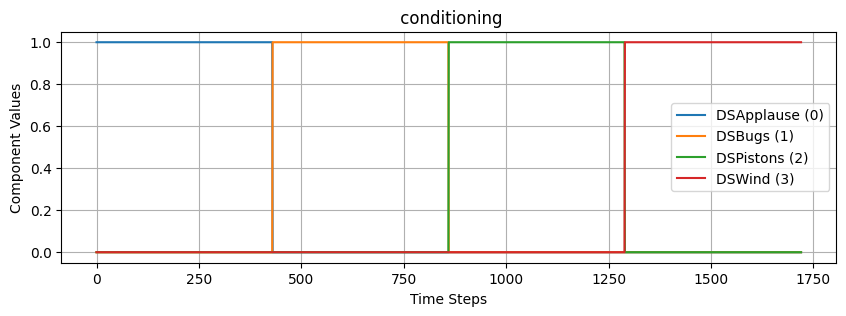

shape of inf_cond is  = torch.Size([1, 1721, 5])
Done


In [37]:
# Generate the conditioning sequence from the breakpoint sequence, and plot the trajectories

if cond_size == 0 :
    inference_cond = None
else : 

    inference_cond=interpolate_vectors(morphs[morphname]['vsequence'], [round(x * inference_steps) for x in morphs[morphname]['vtimes']]) #length must cover staring context window+inf steps


    # Make a plot of any changing parmaeters --------------------------------------------------------------
    # Extract the 2D array of shape [n, m]
    data = inference_cond[0]
    # Find components that change over time
    changing_indices = [i for i in range(cond_size) if not torch.all(data[:, i] == data[0, i])]

    # Plot the changing components
    plt.figure(figsize=(10, 3))

    for i in changing_indices:
        if i != 7 :
            plt.plot(data[:, i], label=f'{dataset.int2classname[i]} ({i})')
        else : 
            plt.plot(data[:, i], label=f'Parameter ({i})', linestyle='--')

    plt.xlabel('Time Steps')
    plt.ylabel('Component Values')
    plt.title(f' {morphname}')
    plt.legend()
    plt.grid(True)
    plt.show()

    inference_cond=inference_cond.to(device)
    print(f'shape of inf_cond is  = {inference_cond.shape}') 



print('Done')

<div style="width: 100%; height: 20px; background-color: black;"></div>

# Run the Transformer to generate the .dac file

In [38]:
outfname=outdir+"/"+ "dacs" + "/" +  morphname + '_chkpt_' + str(cptnum).zfill(4) +  "_steps_"+str(inference_steps).zfill(4) +'.topn_'+ f"{topn:04d}"
print(f'outfname is {outfname}')
inference(model, inference_cond, Ti_context_length, vocab_size, num_codebooks, inference_steps, topn, outfname ) 

outfname is runs/mini_test_01/dacs/conditioning_chkpt_0005_steps_1720.topn_0005
In inference, the shape of the mask is torch.Size([86, 86])
In inference, the shape of the inference_cond passed in is  torch.Size([1, 1721, 5])
 In inference, the shape of input_data (context window) is torch.Size([1, 86, 4])
In inference, the shape of the inference_cond After extending to cover priming input, is  torch.Size([1, 1807, 5])
inference time for 1720 steps, or 20.0 seconds of sound is 8.947663068771362
dacseq shape written to file is of shape torch.Size([1, 4, 1720])


<div style="width: 100%; height: 20px; background-color: black;"></div>

# Decode the transformer-generated tokens to audio

In [39]:
# Get the trained encodec from Descript
# The first time you do this, it can take a while. Go get coffee. After that, it uses a cached version

dacmodel_path = dac.utils.download(model_type="44khz") 
print(f'The DAC decoder is in {dacmodel_path}')
with torch.no_grad():
    dacmodel = dac.DAC.load(dacmodel_path)

    dacmodel.to(device); #wanna see the model? remove the semicolon
    dacmodel.eval();  # need to be "in eval mode" in order to set the number of quantizers

The DAC decoder is in C:\Users\lonce\.cache\descript\dac\weights_44khz_8kbps_0.0.1.pth


C:\ProgramData\miniconda3\envs\dacformer2\lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


 selected_file is runs/mini_test_01/dacs/conditioning_chkpt_0005_steps_1720.topn_0005.dac
dacfile.codes shape is: torch.Size([1, 4, 1720])
decompress time for 19.969160997732427 seconds of sound is 27.297375679016113
asig.audio_data.shape[2] is 880640



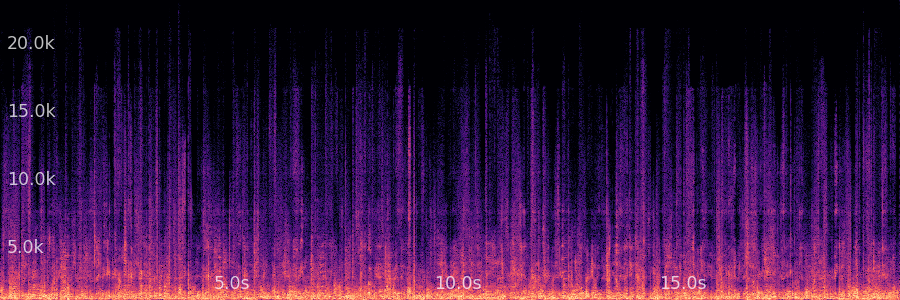
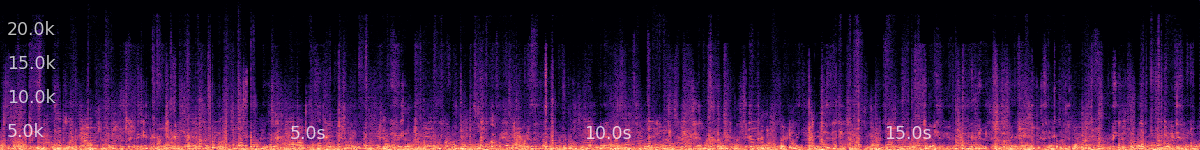

In [40]:
# ------------------------------- 
# --------  Draw the spectrogram 
# ------------------------------- 
selected_file=outfname + ".dac"
print(f' selected_file is {selected_file}')

with torch.no_grad():
    dacfile = dac.DACFile.load(selected_file)
    # FIRST - Decompress it back to an AudioSignal\ from codes to z (1024) to signal   
    print(f'dacfile.codes shape is: {dacfile.codes.shape}')
    t0=time.time()
    asig=dacmodel.decompress(dacfile)
    t1=time.time()
    
    inf_time = t1-t0
    print(f'decompress time for {asig.audio_data.shape[2]/44100} seconds of sound is {inf_time}' )
    print(f'asig.audio_data.shape[2] is {asig.audio_data.shape[2]}')
    
    asig.cpu().widget()
    asig.audio_data.shape

In [41]:
adata = asig.samples.view(-1).numpy()
if SAVEWAV :  
    sf.write(outfname + ".wav", adata, 44100)
    asig.save_image(outfname + ".jpg")
    print(f'saving .wav and .jpg to outfname {outfname}')

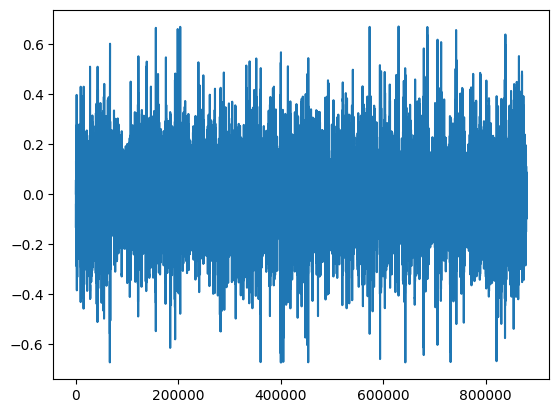

In [42]:
# Audio display
plt.plot(adata)
# Audio player
ipd.Audio(adata, rate=44100) 